## Import & Data Load

In [ ]:
# CatBoost 모델 특징
# 특징1.  CatBoost는 카테고리 특성을 자동으로 처리하는 기능
# 특징2. 대용량 데이터셋에서도 잘 작동함
# 특징3. CatBoost는 기본적으로 대칭 트리를 사용하여 과적합을 줄이는 데 도움
# 특징4. CatBoost는 미세 조정 없이도 좋은 성능을 내는 경향이 있음. 하이퍼파라미터 튜닝에 대한 노력을 덜 해도 괜찮음

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
import bisect
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import catboost


train = pd.read_csv('train.csv').drop(columns=['SAMPLE_ID'])
test = pd.read_csv('test.csv').drop(columns=['SAMPLE_ID'])

## Data Pre-processing

In [2]:
# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])

# datetime을 여러 파생 변수로 변환
for df in [train, test]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday

# datetime 컬럼 제거
train.drop(columns='ATA', inplace=True)
test.drop(columns='ATA', inplace=True)


# 결측치 처리
train.fillna(train.mean(), inplace=True)
test.fillna(train.mean(), inplace=True)

<ipython-input-2-b42cba066898>:20: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  train.fillna(train.mean(), inplace=True)
<ipython-input-2-b42cba066898>:21: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  test.fillna(train.mean(), inplace=True)


## 모델 학습 및 특성 중요도 확인

Model Tune for CatBoost.
Learning rate set to 0.104107
0:	learn: 167.7681713	total: 799ms	remaining: 13m 18s
1:	learn: 165.4861287	total: 1.6s	remaining: 13m 20s
2:	learn: 163.6336643	total: 2.19s	remaining: 12m 8s
3:	learn: 162.0153281	total: 2.76s	remaining: 11m 27s
4:	learn: 160.7305556	total: 3s	remaining: 9m 57s
5:	learn: 159.5273052	total: 3.34s	remaining: 9m 13s
6:	learn: 158.6252580	total: 3.67s	remaining: 8m 40s
7:	learn: 157.7785515	total: 4.14s	remaining: 8m 33s
8:	learn: 157.1471889	total: 4.98s	remaining: 9m 8s
9:	learn: 156.5335441	total: 5.63s	remaining: 9m 17s
10:	learn: 155.9307688	total: 6s	remaining: 8m 59s
11:	learn: 155.5046062	total: 6.34s	remaining: 8m 41s
12:	learn: 155.1872761	total: 6.73s	remaining: 8m 31s
13:	learn: 154.7876655	total: 7.09s	remaining: 8m 19s
14:	learn: 154.4497608	total: 7.37s	remaining: 8m 4s
15:	learn: 154.1125781	total: 7.71s	remaining: 7m 53s
16:	learn: 153.6684562	total: 8.18s	remaining: 7m 53s
17:	learn: 153.3489816	total: 8.65s	remaini

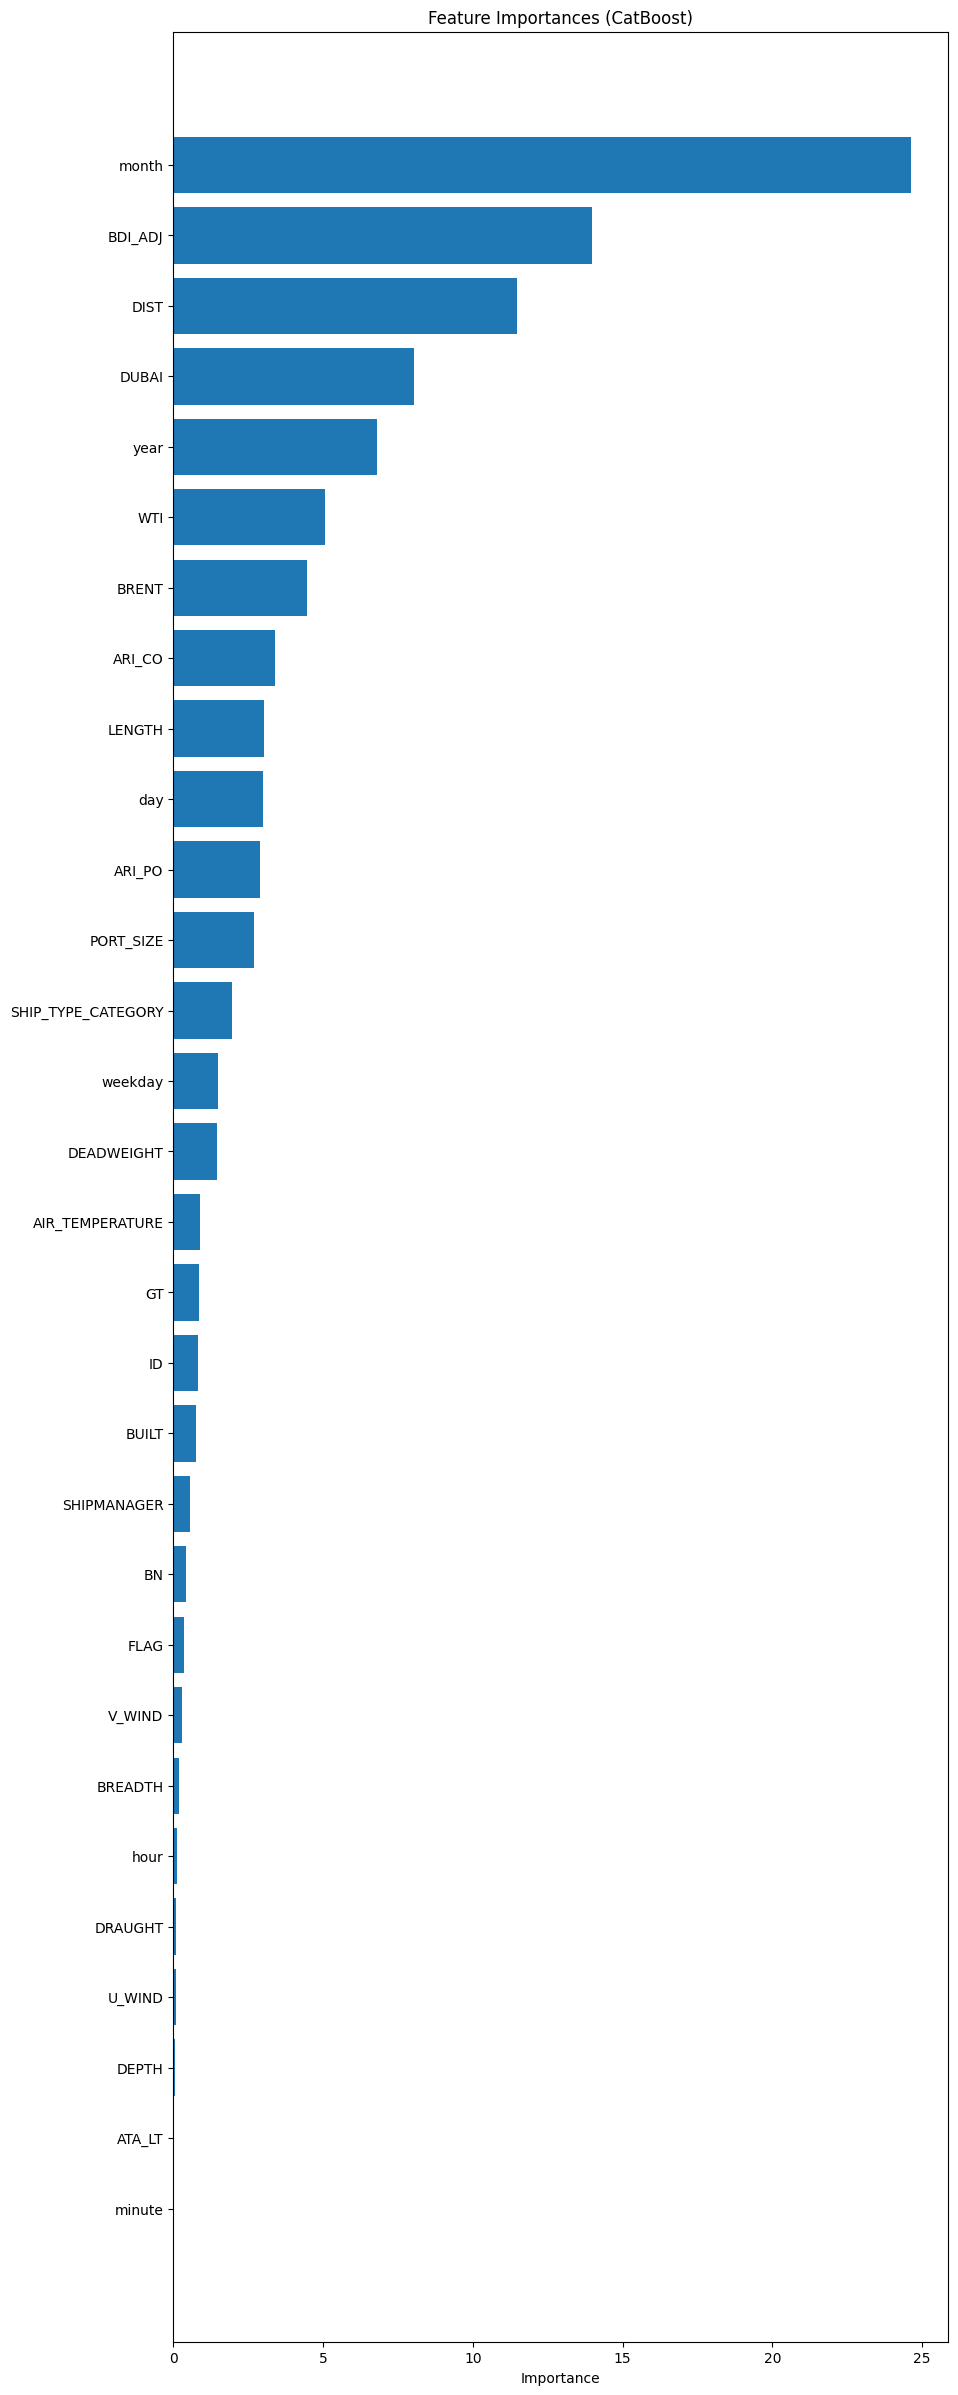

In [3]:
import catboost
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt

def train_and_evaluate(model, model_name, X_train, y_train, cat_features=None):
    print(f'Model Tune for {model_name}.')
    model.fit(X_train, y_train, cat_features=cat_features)

    feature_importances = model.get_feature_importance()
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, len(X_train.columns)))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()

    return model, feature_importances

X_train = train.drop(columns='CI_HOUR')
y_train = train['CI_HOUR']

# 카테고리형 특성의 인덱스를 지정합니다.
cat_features = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ID', 'SHIPMANAGER', 'FLAG']
# CatBoost 모델로 변경
catboost_model = CatBoostRegressor()
catboost_model, catboost_feature_importances = train_and_evaluate(catboost_model, 'CatBoost', X_train, y_train, cat_features)


## 특성 중요도로부터 Feature Selection

In [4]:
threshold = 1  # Your Threshold
low_importance_features = X_train.columns[catboost_feature_importances < threshold]

X_train_reduced = X_train.drop(columns=low_importance_features)
X_test_reduced = test.drop(columns=low_importance_features)


## K-Fold Model Fitting & Validation

In [15]:
X_t.head()

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,DEADWEIGHT,LENGTH,DUBAI,BRENT,WTI,BDI_ADJ,PORT_SIZE,year,month,day,weekday
0,CN,EKP8,Bulk,30.736578,73100,220.0,42.01,43.16,40.96,1407.668330,0.001660,2020,10,15,3
1,CN,EUC8,Container,63.220425,37900,220.0,67.53,64.55,59.34,2089.046774,0.001614,2019,9,17,1
3,JP,TMR7,Cargo,0.000000,1490,70.0,43.02,43.15,41.11,1169.853455,0.000069,2020,9,18,4
4,RU,NNC2,Container,8.813725,27600,180.0,90.45,93.65,88.11,1107.944894,0.000197,2022,8,13,5
5,CN,NGG6,Container,81.435335,18100,160.0,45.75,48.89,45.92,820.288044,0.001743,2015,9,8,1


In [20]:
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import numpy as np
from tqdm import tqdm

# CatBoost 모델 초기화
catboost_model = CatBoostRegressor()

# 5-Fold 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
ensemble_predictions = []
scores = []

for train_idx, val_idx in tqdm(kf.split(X_train_reduced), total=5, desc="Processing folds"):
    X_t, X_val = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
    y_t, y_val = y_train[train_idx], y_train[val_idx]

    # CatBoost 모델 학습
    cat_features_idx = ['ARI_CO','ARI_PO','SHIP_TYPE_CATEGORY']
    catboost_model.fit(X_t, y_t, cat_features=cat_features_idx)

    # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
    val_pred = catboost_model.predict(X_val)

    # Validation set에 대한 대회 평가 산식 계산 후 저장
    scores.append(mean_absolute_error(y_val, val_pred))

    # test 데이터셋에 대한 예측 수행 후 저장
    catboost_pred = catboost_model.predict(X_test_reduced)
    catboost_pred = np.where(catboost_pred < 0, 0, catboost_pred)

    ensemble_predictions.append(catboost_pred)

# K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
final_predictions = np.mean(ensemble_predictions, axis=0)

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score 출력
print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))


Processing folds:   0%|          | 0/5 [00:00<?, ?it/s]

Learning rate set to 0.1005
0:	learn: 168.1546035	total: 377ms	remaining: 6m 16s
1:	learn: 165.9219415	total: 736ms	remaining: 6m 7s
2:	learn: 164.0951202	total: 1s	remaining: 5m 33s
3:	learn: 162.5398424	total: 1.15s	remaining: 4m 46s
4:	learn: 161.2375532	total: 1.33s	remaining: 4m 24s
5:	learn: 160.0585928	total: 1.48s	remaining: 4m 5s
6:	learn: 159.0898995	total: 1.64s	remaining: 3m 53s
7:	learn: 158.2751356	total: 1.8s	remaining: 3m 43s
8:	learn: 157.4913273	total: 1.96s	remaining: 3m 35s
9:	learn: 156.8782740	total: 2.1s	remaining: 3m 28s
10:	learn: 156.3445653	total: 2.25s	remaining: 3m 22s
11:	learn: 155.8836809	total: 2.44s	remaining: 3m 20s
12:	learn: 155.4143265	total: 2.59s	remaining: 3m 16s
13:	learn: 155.0374975	total: 2.76s	remaining: 3m 14s
14:	learn: 154.6458975	total: 2.95s	remaining: 3m 14s
15:	learn: 154.3595357	total: 3.11s	remaining: 3m 11s
16:	learn: 153.9961271	total: 3.31s	remaining: 3m 11s
17:	learn: 153.7262710	total: 3.44s	remaining: 3m 7s
18:	learn: 153.482

Processing folds:  20%|██        | 1/5 [03:17<13:09, 197.28s/it]

Learning rate set to 0.1005
0:	learn: 167.3957775	total: 226ms	remaining: 3m 45s
1:	learn: 165.1639328	total: 402ms	remaining: 3m 20s
2:	learn: 163.3297252	total: 517ms	remaining: 2m 51s
3:	learn: 161.8481849	total: 681ms	remaining: 2m 49s
4:	learn: 160.5380502	total: 873ms	remaining: 2m 53s
5:	learn: 159.3994384	total: 999ms	remaining: 2m 45s
6:	learn: 158.4803477	total: 1.13s	remaining: 2m 40s
7:	learn: 157.6936326	total: 1.28s	remaining: 2m 38s
8:	learn: 157.0804707	total: 1.41s	remaining: 2m 35s
9:	learn: 156.5400594	total: 1.55s	remaining: 2m 33s
10:	learn: 156.0127390	total: 1.72s	remaining: 2m 34s
11:	learn: 155.5546818	total: 1.84s	remaining: 2m 31s
12:	learn: 155.2113587	total: 1.97s	remaining: 2m 29s
13:	learn: 154.7927643	total: 2.12s	remaining: 2m 29s
14:	learn: 154.3488136	total: 2.3s	remaining: 2m 30s
15:	learn: 153.9550351	total: 2.47s	remaining: 2m 31s
16:	learn: 153.6304643	total: 2.64s	remaining: 2m 32s
17:	learn: 153.3387818	total: 2.8s	remaining: 2m 32s
18:	learn: 1

Processing folds:  40%|████      | 2/5 [06:31<09:45, 195.23s/it]

Learning rate set to 0.1005
0:	learn: 167.5412458	total: 195ms	remaining: 3m 14s
1:	learn: 165.3177359	total: 369ms	remaining: 3m 4s
2:	learn: 163.4852338	total: 488ms	remaining: 2m 42s
3:	learn: 161.9644947	total: 660ms	remaining: 2m 44s
4:	learn: 160.6280076	total: 823ms	remaining: 2m 43s
5:	learn: 159.5979431	total: 964ms	remaining: 2m 39s
6:	learn: 158.6991161	total: 1.1s	remaining: 2m 36s
7:	learn: 157.9214539	total: 1.24s	remaining: 2m 33s
8:	learn: 157.2047704	total: 1.39s	remaining: 2m 33s
9:	learn: 156.6409842	total: 1.5s	remaining: 2m 28s
10:	learn: 156.0893245	total: 1.67s	remaining: 2m 30s
11:	learn: 155.5554945	total: 1.89s	remaining: 2m 35s
12:	learn: 155.1646178	total: 2.07s	remaining: 2m 36s
13:	learn: 154.8597723	total: 2.23s	remaining: 2m 36s
14:	learn: 154.4551036	total: 2.39s	remaining: 2m 37s
15:	learn: 154.1848586	total: 2.53s	remaining: 2m 35s
16:	learn: 153.8350855	total: 2.72s	remaining: 2m 37s
17:	learn: 153.5609475	total: 2.94s	remaining: 2m 40s
18:	learn: 15

Processing folds:  60%|██████    | 3/5 [09:49<06:33, 196.84s/it]

Learning rate set to 0.1005
0:	learn: 168.2416743	total: 190ms	remaining: 3m 10s
1:	learn: 165.9994244	total: 369ms	remaining: 3m 4s
2:	learn: 164.1519891	total: 499ms	remaining: 2m 45s
3:	learn: 162.6708766	total: 683ms	remaining: 2m 50s
4:	learn: 161.3628897	total: 846ms	remaining: 2m 48s
5:	learn: 160.2076456	total: 982ms	remaining: 2m 42s
6:	learn: 159.2661000	total: 1.15s	remaining: 2m 43s
7:	learn: 158.4583241	total: 1.27s	remaining: 2m 37s
8:	learn: 157.7264386	total: 1.44s	remaining: 2m 38s
9:	learn: 157.0810882	total: 1.62s	remaining: 2m 40s
10:	learn: 156.5307670	total: 1.82s	remaining: 2m 43s
11:	learn: 156.1277907	total: 1.96s	remaining: 2m 41s
12:	learn: 155.6911145	total: 2.15s	remaining: 2m 43s
13:	learn: 155.3667330	total: 2.29s	remaining: 2m 41s
14:	learn: 154.9791010	total: 2.44s	remaining: 2m 40s
15:	learn: 154.6067434	total: 2.59s	remaining: 2m 39s
16:	learn: 154.2597147	total: 2.75s	remaining: 2m 39s
17:	learn: 153.9570506	total: 2.94s	remaining: 2m 40s
18:	learn: 

Processing folds:  80%|████████  | 4/5 [13:05<03:16, 196.26s/it]

Learning rate set to 0.1005
0:	learn: 167.9314162	total: 369ms	remaining: 6m 8s
1:	learn: 165.6972801	total: 691ms	remaining: 5m 44s
2:	learn: 163.8617754	total: 811ms	remaining: 4m 29s
3:	learn: 162.3353461	total: 975ms	remaining: 4m 2s
4:	learn: 160.9839115	total: 1.12s	remaining: 3m 42s
5:	learn: 159.8557914	total: 1.28s	remaining: 3m 31s
6:	learn: 158.9316324	total: 1.42s	remaining: 3m 21s
7:	learn: 158.1503943	total: 1.54s	remaining: 3m 11s
8:	learn: 157.4504804	total: 1.68s	remaining: 3m 5s
9:	learn: 156.8658863	total: 1.83s	remaining: 3m 1s
10:	learn: 156.3422826	total: 1.99s	remaining: 2m 58s
11:	learn: 155.8037986	total: 2.15s	remaining: 2m 56s
12:	learn: 155.3589993	total: 2.35s	remaining: 2m 58s
13:	learn: 154.8761790	total: 2.54s	remaining: 2m 58s
14:	learn: 154.5691685	total: 2.68s	remaining: 2m 56s
15:	learn: 154.2729297	total: 2.87s	remaining: 2m 56s
16:	learn: 154.0481775	total: 3.08s	remaining: 2m 58s
17:	learn: 153.7238068	total: 3.25s	remaining: 2m 57s
18:	learn: 153

Processing folds: 100%|██████████| 5/5 [16:21<00:00, 196.33s/it]

Validation : MAE scores for each fold: [41.92915906336246, 43.850349912387614, 42.86494971685781, 42.792995013938864, 42.42852863186254]
Validation : MAE: 42.77319646768186


## Submission

In [22]:
submit = pd.read_csv('./sample_submission.csv')
submit['CI_HOUR'] = final_predictions
submit.to_csv('./catboost_submit.csv', index=False)

In [ ]:
train